# FXa protein: 30x4 Cross Validation
## Data load and preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%run ../modules/run_or_load_decorator.py
%run ../modules/plotting_metrics.py

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%run ./1_Helper_functions.ipynb

In [4]:
protein_name='fxa'
file_name = '../../../FXa/ANALISIS/6_Machine_Learning_Models/' + \
'df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
y_true_merged = X_merged_dksc['activity']
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

# Simplify the names
X = X_merged_dksc.values
y = y_true_merged.values


R_a = round(y.sum() / len(y), 3)
print(X.shape)
print(y.sum())
print('Ra =', R_a)

(6233, 136)
300
Ra = 0.048


## Estimators
### ML Classifiers

In [5]:
from sklearn.dummy import DummyClassifier

hyparams = {'strategy': "stratified"}
dclf = DummyClassifier(**hyparams)

In [6]:
from sklearn.linear_model import LogisticRegression 

hyparams = {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear', 'max_iter':400}
lr = LogisticRegression(**hyparams)

In [7]:
from xgboost import XGBClassifier

hyparams ={'subsample': 0.5, 'n_estimators': 200, 
           'max_depth': 10, 'learning_rate': 0.1, 
           'gamma': 1, 'colsample_bytree': 0.5, 'alpha': 0.5}
xgb = XGBClassifier(**hyparams)

In [8]:
# ML Classifier
ml_classifiers = {
    'lr': lr,
    'xgb': xgb,
    'dclf': dclf
}

# update names
ml_classifiers = {f'ml_{name}': clf 
                for name, clf in ml_classifiers.items()}

### Consensus Scorings

In [9]:
%run ../6_Machine_Learning_Models/5_Helper_Consensus_Scoring.ipynb

cs_functions = {
    'MEAN': get_mean_score,
    'MAX': get_max_score,
    'MIN': get_min_score,
}

# update names
cs_functions = {f'cs_{name}': func 
                for name, func in cs_functions.items()}

### Estimators dictionary 

In [10]:
estimators = {**ml_classifiers, **cs_functions}

### Evaluation metrics 

In [11]:
metrics=dict(roc_auc = {'metric_name': 'roc_auc'},
             nef_05_Ra = {'metric_name': 'ef', 
                    'fraction': R_a, 'method':'normalized'},
             pROC = {'metric_name': 'p_roc'},
             pr_auc = {'metric_name': 'pr_auc'}
            )

# 30x4 CV evaluation

In [12]:
# Save the results to a file to ommit repeate the analysis
@run_or_load_joblib
def nk_rep_cross_validation_SAVE(filename, **kwargs):
    return nk_rep_cross_validation(**kwargs)

In [13]:
%run ./1_Helper_functions.ipynb


The following procedure performs a P number of assays of K-fold CV.
To track which instances where used for training and testing the `nk_rep_cross_validation()` function also returns the predictions of each model and the split sets, in order to identify which observations were correctly predicted.

- y_preds:
    - Contains the PxK predictions of each method
- splits
    - List that contains PxK tuples with two elements: The train and test indexes.

In [14]:
%%time

n_repeats = 30
n_splits = 4

# **********************
# Perform the evaluation
# **********************
evaluation_name=f'{n_repeats}x{n_splits}cv'
cv30x4, y_preds, splits = nk_rep_cross_validation_SAVE(
    filename=f'./cachedir/{evaluation_name}_{protein_name}',
    estimators=estimators, X=X, y=y, metrics=metrics, 
                      n_repeats=n_repeats, n_splits=n_splits,
    y_preds_return=True,
    random_state=42)

# Rename columns 
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csMAX', 'csMIN']
# full_names = ['Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN']
# full_names = ['1-NN', 'Log. Reg.', 'XGB', 'DummyClf', 'csMEAN', 'csMAX', 'csMIN', 'csVOTE']
new_names = dict(zip(
    [*cv30x4.columns],
    full_names))
cv30x4 = cv30x4.rename(columns=new_names)

# ***************************
# Drop 1NN and csVOTE methods
# ***************************
# cv30x4 = cv30x4.drop(['1-NN', 'csVOTE'], axis=1)
# Update Full names list
full_names = ['LR', 'GBT', 'DClf', 'csAVG', 'csMAX', 'csMIN']

# **********************************
# Extract the individual predictions
# **********************************
# y_preds: Model predictions
# get the test indices
test_sets_idxs = [i[1] for i in splits]

File loaded: ./cachedir/30x4cv_fxa
CPU times: user 87.7 ms, sys: 20.8 ms, total: 109 ms
Wall time: 164 ms


In [15]:
# aun se necesita quedarse solo con los del test set
k=4
test_sets_idxs = [i[1] for i in splits]

# unir las predicciones con los indices
m_name = 'ml_xgb'
P=120
# Iterar entre el numero de sets = PxK
# Como resultado se obtiene una lista con PxK elementos, cada uno es un Dataframe con una unica columna
# As a result we get a list of PxK elements, each one is a Dataframe with just one column
sets_preds = [pd.DataFrame(y_preds[m_name][i], index=test_set).rank(ascending=False)
     for i, test_set in enumerate(test_sets_idxs)]
# Concatenar por pares la lista de dataframes
# Now we need to concat each K consecutive elements to get the full column with all observations
# Concat rows

def every_k_elements(array, k):
    assert len(array) % k == 0
    chunks = []
    for i in range(0, len(array), k):
        chunks.append( array[i: i+k])
    return chunks

chunks = every_k_elements(sets_preds, k=k)

final_ranks = pd.concat([pd.concat(chunk, axis=0) for chunk in chunks], axis=1)

# .mean(axis=1).rank()

# # Identify the molecules
# # final_ranks.index = y_true_merged.index
# final_df = pd.DataFrame({'y': y_true_merged.values, 'rank': final_ranks.values}, index= y_true_merged.index)
# final_df

# final_df.query('y == 1').median(axis=0)
# final_df.query('y == 0').median(axis=0)
n_a = y_true_merged.sum()
thr = n_a / k
print(thr)
df_fin = final_ranks.applymap(lambda x: x < thr).sum(axis=1)
df_fin = pd.DataFrame({'y': y_true_merged.values, 'rank': df_fin.values}, index= y_true_merged.index)
a = df_fin.sort_values('rank', ascending=False).query('y == 0')
a['rank'].value_counts()#.sort_index()

75.0


0     5180
1      268
2      103
3       71
4       52
5       38
6       26
30      23
8       17
11      16
7       14
12      14
10      13
13      11
14      11
25      10
9       10
15       6
17       6
28       5
24       5
22       5
16       4
27       4
18       4
26       4
29       4
21       3
20       3
23       2
19       1
Name: rank, dtype: int64

In [16]:
%run Friedman_and_Nemenyi_test.ipynb
%load_ext rpy2.ipython

## AUC-ROC

In [17]:
# ROC-AUC
metric_name='roc_auc'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))

display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

         LR       GBT      DClf     csAVG     csMAX     csMIN
0  0.974476  0.995426  0.989150  0.978809  0.986502  0.985609
1  0.022047  0.967027  0.461527  0.055206  0.278969  0.232886


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,0,1,1,1,1,1


,statistic,p
Bartlett,176.855402,2.511479e-36


,chi^2,dof,p_value
Friedman Test,593.861905,5,4.286126e-126


In [18]:
%%R -i full_names -i df_R -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.4, y_max=1,
              dot_size=4, scale='area', violin_width=1.2) +
add_ref_values('mean SCP', single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

R[write to console]: Registering fonts with R

R[write to console]: Error: package or namespace load failed for ‘ggthemes’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘scales’

R[write to console]: Además: 
R[write to console]: Warning messages:

R[write to console]: 1: package ‘extrafont’ was built under R version 3.6.3 

R[write to console]: 2: package ‘ggthemes’ was built under R version 3.6.3 




Error: package or namespace load failed for ‘ggthemes’ in loadNamespace(i, c(lib.loc, .libPaths()), versionCheck = vI[[i]]):
 there is no package called ‘scales’


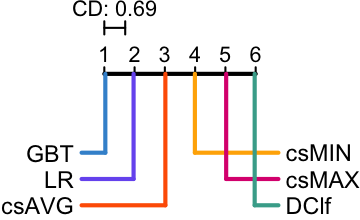

In [45]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)

R[write to console]: 
Attaching package: ‘reshape2’


R[write to console]: The following object is masked from ‘package:tidyr’:

    smiths


R[write to console]: PMCMR is superseded by PMCMRplus and will be no longer maintained. You may wish to install PMCMRplus instead.



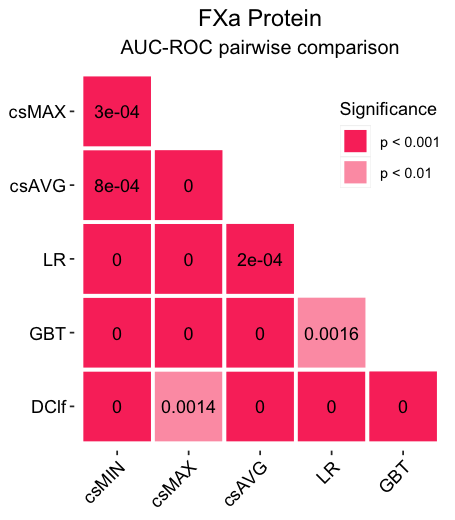

In [46]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="AUC-ROC pairwise comparison")

# Save the picture
protein_name <- 'FXa'
methodology <- '30x4CV'
metric <- 'ROC-AUC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p

## pAUC-ROC Normalized

In [47]:
# Random value given n_a and N
test_size=0.25
N = y.size*test_size
n_a = y.sum()*test_size
print(N, n_a)
pROC_base_random = pROC_auc_rand(N, n_a, normalized=True)
print('Max pACU-ROC (non-normalized):', 1/N)
pROC_base_random

1558.25 75.0
Max pACU-ROC (non-normalized): 0.0006417455478902615


0.13594271974047575

In [48]:
# ROC-AUC
metric_name='pROC'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics[metric_name], n_reps=30, test_size=0.5, random_state=42)

         LR       GBT          DClf     csAVG     csMAX     csMIN
0  0.995884  0.990176  8.714213e-01  0.984302  0.977285  0.988491
1  0.981009  0.550139  8.714986e-09  0.177719  0.039889  0.409560


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,1,1,0,1,0,1


,statistic,p
Bartlett,133.170941,5.052159e-27


,chi^2,dof,p_value
Friedman Test,582.595238,5,1.164542e-123


In [49]:
%%R -i full_names -i df_R -i single_mean -i single_max -ipROC_base_random -w 6 -h 4 --units in -r 300
source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

# plot_swarm_box(df_R, cbbPalette, decreasing_order = FALSE, y_min=0.0, y_max=1., 
#                dot_size=4, bin_width=0.002,
#                y_label='AUC-pROC', base_h_line=pROC_base_random) +
# add_ref_values('min SCP', single_mean, color='cadetblue4') + 
# add_ref_values('max SCP', single_max, color='coral1')

In [50]:
%%R -i df_R -i full_names -w 5 -h 2 --units in -r 150
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- full_names

par(family = "Trebuchet MS")
# plotCD_color(df_R, alpha=0.05, cex=.9, colPalette=cbbPalette)

In [51]:
%%R -i df_R -w 4 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

# plot_p_vals_heatmap(df_R)

## EF 5% = Ra

In [52]:
# ROC-AUC
metric_name='nef_05_Ra'

# Normality
display(multi_norm_test(cv30x4, metric=metric_name))
# Homocedasticity
display(multi_homovar_test(cv30x4, metric=metric_name))
# Friedman test
display(friedmanTest(cv30x4.loc[metric_name]))

df_R = order_df(cv30x4, metric_name).loc[metric_name]
df_Rmelted = pd.melt(df_R, var_name='method', value_name='score')

# Single conformation reference values
single_mean, single_max = n_hold_out_single_performance(X, y, 
                            metrics['nef_05_Ra'], n_reps=30, test_size=0.5, random_state=42)

         LR       GBT      DClf     csAVG     csMAX     csMIN
0  0.970648  0.985253  0.940342  0.981855  0.962397  0.971928
1  0.010002  0.216488  0.000045  0.105892  0.001980  0.012995


,LR,GBT,DClf,csAVG,csMAX,csMIN
Normality,0,1,0,1,0,0


,statistic,p
Bartlett,57.608156,3.788842e-11


,chi^2,dof,p_value
Friedman Test,578.957143,5,7.113620e-123


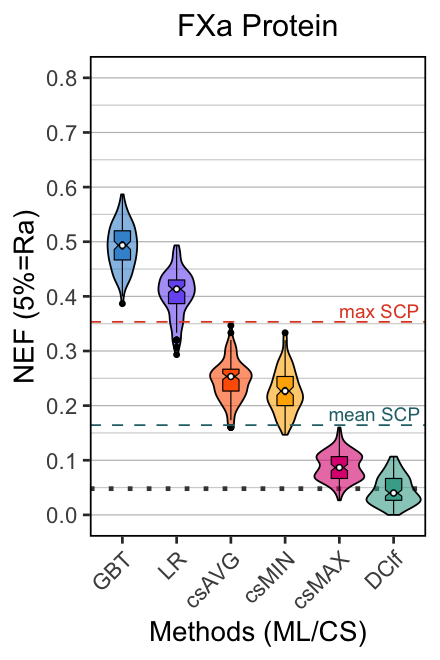

In [53]:
%%R -i full_names -i df_R -i R_a -i single_mean -i single_max  -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_violin(df_R, cbbPalette, decreasing_order = TRUE, y_min=0.0, y_max=0.8,
              dot_size=4, scale='area', violin_width=1., base_h_line=R_a,
               y_label='NEF (5%=Ra)') +
add_ref_values('mean SCP', x=4.8, single_mean, color='#297177', size=2.4, y_add=0.02) + 
add_ref_values('max SCP', x=5, single_max, color='#E1492B', size=2.4, y_add=0.02) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'violin.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

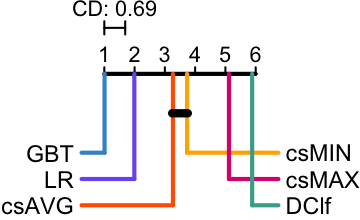

In [54]:
%%R -i df_R -i full_names -w 1.8 -h 1.1 --units in -r 200
library(scmamp)

source('./plotCD.R')

cbbPalette <- hue_pal()(ncol(df_R))
cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

# Save the figure
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'nemenyiCD.pdf', sep='_'))

pdf(filename, 1.8, 1.1)
plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)
dev.off()

plotCD_color(df_R, alpha=0.05, cex=.65, labels.cex=0.7, colPalette=cbbPalette, side_marging=10)


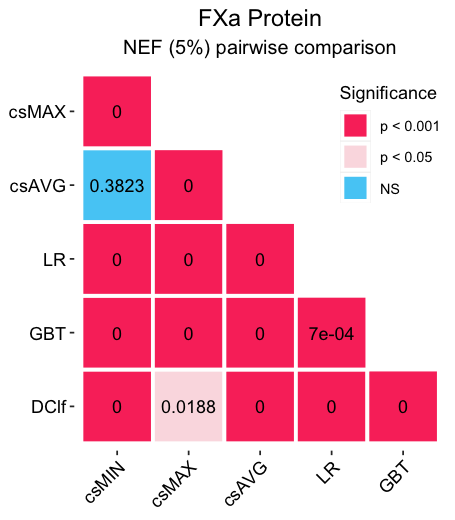

In [55]:
%%R -i df_R -w 3.5 -h 4 --units in -r 130

source('./plot_p_vals_heatmap.R')

p = plot_p_vals_heatmap(df_R) +
labs(title='FXa Protein', subtitle="NEF (5%) pairwise comparison")

# Save the picture
protein_name <- 'fxa'
methodology <- '30x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, 'significance.pdf', sep='_'))
ggsave(filename, plot=p, width=3.5, height= 4)
p


# Y-randomization test

In [56]:
%%time 

n_repeats = 10
n_splits = 4

# time 29.5 min
chi_fractions = [1, 0.75, 0.5, 0.25, 0.0]
chi_results = {}
evaluation_name = f'y_scrambling_reps_{n_repeats}x{n_splits}CV'

for chi in chi_fractions:
    filename = f'./cachedir/{evaluation_name}_{protein_name}_chi-{chi}'
    result = nk_rep_cross_validation_scrambling(filename=filename, 
                             random_chi=chi, estimators=estimators, 
                             X=X, y=y, metrics=metrics, 
                             n_repeats=n_repeats, n_splits=n_splits,
                             y_preds_return=True)
    print(f'Fraction chi={chi} finished.')
    chi_results[f'chi_{chi}'] = result

File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-1
Fraction chi=1 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.75
Fraction chi=0.75 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.5
Fraction chi=0.5 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.25
Fraction chi=0.25 finished.
File loaded: ./cachedir/y_scrambling_reps_10x4CV_fxa_chi-0.0
Fraction chi=0.0 finished.
CPU times: user 16.5 ms, sys: 4.72 ms, total: 21.2 ms
Wall time: 23 ms


## AUC-ROC

In [57]:
df_y_random = get_group_stats(chi_results, metric_name='roc_auc')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

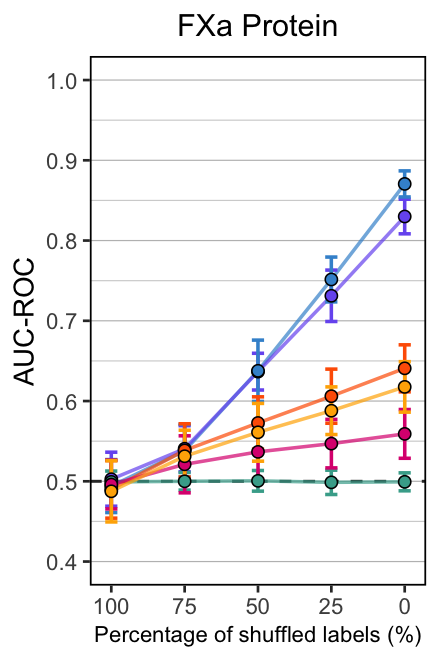

In [58]:
%%R -i df_y_random -i full_names -i df_R -w 2.2 -h 3.3 --units in -r 200

source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=1.8, line_size=0.6,
           error_size=0.6, error_dodge=0.05, error_width=25) +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'AUC-ROC'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p

## AUC-pROC Normalized

In [59]:
df_y_random = get_group_stats(chi_results, metric_name='pROC')
df_y_random = df_y_random.replace(new_names)

In [60]:
%%R -i df_y_random -i df_R -i pROC_base_random -w 9 -h 4 --units in -r 130

source('./plotSwarmBox.R')

cbbPalette <- hue_pal()(ncol(df_R))
names(cbbPalette) <- colnames(df_R)

# plot_lines(df_y_random, cbbPalette, y_min=0.0, y_max=1., 
#                y_label='AUC-pROC', base_h_line=pROC_base_random)

## EF 12% 

In [61]:
df_y_random = get_group_stats(chi_results, metric_name='nef_12_Ra')
df_y_random = df_y_random.replace(new_names)
df_y_random = df_y_random[df_y_random['method'].isin(full_names)]

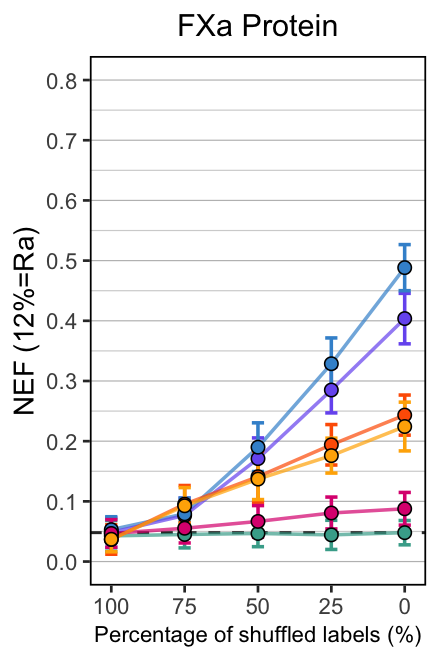

In [62]:
%%R -i df_y_random -i full_names -i R_a -i df_R -w 2.2 -h 3.3 --units in -r 200
 
source('./plotSwarmBox.R')

cbbPalette <- c( '#785EF0', '#3F93D2', '#44AA99', '#FE6100', '#DC267F', '#FFB000')
names(cbbPalette) <- full_names

p = plot_lines(df_y_random, cbbPalette, point_size=2., line_size=0.6,
           error_size=0.6, error_dodge=0.05, error_width=25,
           y_min=0, y_max=0.8, base_h_line=R_a, y_label='NEF (12%=Ra)') +
ggtitle('FXa Protein')

# Save the picture
protein_name <- 'fxa'
methodology <- 'y-scramb-10x4CV'
metric <- 'NEF'
filename <- paste0('images/fxa/', paste(protein_name, methodology, metric, '.pdf', sep='_'))
ggsave(filename, plot=p, width=2.2, height= 3.3) 
p